In [1]:
import pandas as pd
df = pd.read_csv('sentiment.csv')
df.head(5)

,tag,text
0,P,店家很給力，快遞也是相當快，第三次光顧啦
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。
2,P,不錯，在同等檔次酒店中應該是值得推薦的！
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字


In [2]:
print(len(df))
print(df['tag'].value_counts())

6388
N    3347
P    3041
Name: tag, dtype: int64


In [4]:
with open('停用詞.txt','r',encoding="utf-8") as f:
    ans=[]
    for line in f.readlines():
        stop_words=line.strip('\n')
        ans.append(stop_words)

In [6]:
import jieba
df['token_text'] = df['text'].apply(lambda x:list(jieba.cut(x)))
def remove_stop_words(seg_list):
    new_list=[]
    for seg in seg_list:
        if seg not in ans and seg!=" ":
            new_list.append(seg) #若在for loop裡用remove的話則會改變總長度
    return new_list
df['token_text']=df["token_text"].apply(remove_stop_words)
df.head()

,tag,text,token_text
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 給力, 快遞, 相當快, 第三次, 光顧]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[配置, Vista, 系統, 有點, 卡, 指紋, 收集器, 沒送, 原裝, 滑鼠, 需要..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, 同等, 檔次, 酒店, 中應, 值得, 推薦]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[不會, 蒙牛, 乾, 嚴懲, 真凶]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 三立, 電視, 臺, 女主播, 做, 序, 尤其, 無趣, 像是, 硬, 湊..."


In [7]:
def count(data):
    term_dict = {}
    for doc in data:
        for term in doc:
            if term not in term_dict:
                term_dict[term] = 1
            else:
                term_dict[term] = term_dict[term] +1
    return term_dict
df_p = df[df['tag']=="P"]
df_n = df[df['tag']=="N"]
word_p = count(df_p['token_text'])
word_p = pd.DataFrame(list(word_p.items()), columns=['word', 'TF_p'])

word_n = count(df_n['token_text'])
word_n = pd.DataFrame(list(word_n.items()), columns=['word', 'TF_n'])

In [8]:
word_p['len'] = word_p['word'].apply(lambda x: len(x))
word_n['len'] = word_n['word'].apply(lambda x: len(x))
word_p = word_p[word_p.len>1]
word_n = word_n[word_n.len>1]
word_all = pd.merge(word_p[['TF_p','word']], word_n[['TF_n','word']], how='inner')
word_all.head(5)

,TF_p,word,TF_n
0,7,店家,1
1,18,快遞,9
2,10,第三次,1
3,855,不錯,52
4,7,同等,1


In [9]:
import numpy as np
word_all['positive'] = word_all.TF_p/sum(word_all.TF_p)
word_all['negative'] = word_all.TF_n/sum(word_all.TF_n)
word_all['log_ratio'] = np.log(word_all['positive']/word_all['negative'])
word_all['type'] = word_all['log_ratio'].apply(lambda x: 'Positive' if x>=0 else 'Negative')
word_all = word_all.sort_values(by='log_ratio', ascending=False)
most_p = word_all[:10]
most_p

,TF_p,word,TF_n,positive,negative,log_ratio,type
417,64,比高,1,0.003301,0.000053,4.126757,Positive
270,49,時尚,1,0.002527,0.000053,3.859694,Positive
338,29,光明,1,0.001496,0.000053,3.335169,Positive
91,29,感謝,1,0.001496,0.000053,3.335169,Positive
381,27,正品,1,0.001393,0.000053,3.263710,Positive
383,26,好吃,1,0.001341,0.000053,3.225970,Positive
305,26,合適,1,0.001341,0.000053,3.225970,Positive
148,25,幸福,1,0.001289,0.000053,3.186749,Positive
743,25,挺快,1,0.001289,0.000053,3.186749,Positive
377,123,漂亮,5,0.006344,0.000266,3.170620,Positive


In [10]:
most_n = word_all[-10:]
most_n

,TF_p,word,TF_n,positive,negative,log_ratio,type
1799,2,關機,32,0.000103,0.001704,-2.804715,Negative
1946,1,太慢,17,0.000052,0.000905,-2.865340,Negative
1087,1,招待所,17,0.000052,0.000905,-2.865340,Negative
684,2,再也,36,0.000103,0.001917,-2.922498,Negative
1275,2,太差,48,0.000103,0.002556,-3.210180,Negative
1783,2,垃圾,63,0.000103,0.003355,-3.482114,Negative
1760,4,抵制,134,0.000206,0.007137,-3.543672,Negative
1867,1,不了,36,0.000052,0.001917,-3.615645,Negative
2253,1,根本,39,0.000052,0.002077,-3.695688,Negative
1697,2,內容,116,0.000103,0.006178,-4.092569,Negative


C:\Users\POPO\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\POPO\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


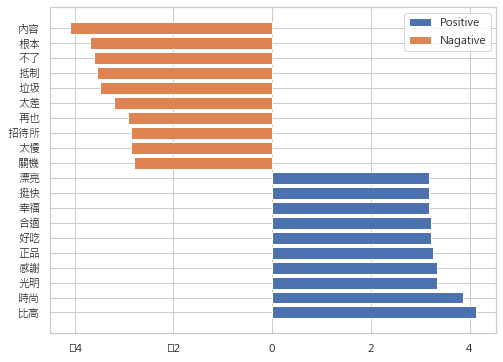

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(8, 6)) 
plt.rcParams.update({'font.size': 12})

plt.barh(most_p['word'],most_p['log_ratio'], label="Positive")
plt.barh(most_n['word'],most_n['log_ratio'], label="Nagative")
plt.legend()
plt.show()

In [17]:
from gensim.models import Word2Vec
model = Word2Vec(df['token_text'],size=300, min_count=1,sg=1, window=5) 

C:\Users\POPO\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [18]:
def avg_w2v_vector(text_list):
    sum_vec = sum([model[word] if word in model else np.zeros(300) for word in text_list])
    result = sum_vec/(len(text_list))
    return result
df["length"]=df['token_text'].apply(lambda x: len(x))
df=df[df["length"]!=0]
df['doc_vec'] = df['token_text'].apply(lambda x: avg_w2v_vector(x))
df.head()

C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,tag,text,token_text,length,doc_vec
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 給力, 快遞, 相當快, 第三次, 光顧]",6,"[0.021693505, 0.03286847, 0.016070377, 0.15529..."
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[配置, Vista, 系統, 有點, 卡, 指紋, 收集器, 沒送, 原裝, 滑鼠, 需要...",13,"[0.019340975, 0.053280756, 0.016247656, 0.2718..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, 同等, 檔次, 酒店, 中應, 值得, 推薦]",7,"[-0.028970191, 0.051705487, -0.010960196, 0.25..."
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[不會, 蒙牛, 乾, 嚴懲, 真凶]",5,"[0.084626034, 0.022331407, 0.054911874, 0.1232..."
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 三立, 電視, 臺, 女主播, 做, 序, 尤其, 無趣, 像是, 硬, 湊...",14,"[0.017287778, 0.03311464, 0.014960043, 0.16823..."


In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 123)
print(len(train))
print(len(test))

5104
1277


In [20]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=1000, max_depth=15,random_state=0)
clf.fit(list(train['doc_vec']), train['tag'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [21]:
result = clf.predict(list(test['doc_vec']))
test['predict_log'] = result

C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
print(sum(test['tag']==test['predict_log'])/len(test))

0.7635082223962412
